# Performance Analysis

In [52]:
import sys
import pandas as pd
import numpy as np
import pickle as pkl
from keras.models import load_model
import seaborn as sbn
from matplotlib import pyplot as plt
import statsmodels.api as sm 
import statsmodels.formula.api as smf

In [2]:
dose_names = ['DOSE_0.01', 'DOSE_0.04','DOSE_0.12','DOSE_0.37','DOSE_1.11','DOSE_3.33','DOSE_10.00']
DOSES = np.array([0.01, 0.04, 0.12, 0.37, 1.11, 3.33, 10.0])

In [3]:
model = load_model('./../best_model/best_model.159-55.24.h5')

In [4]:
data = pd.read_csv('../data/performance_analysis_set.csv').drop(['Unnamed: 0'], axis='columns')
x = data[dose_names].values

print(data.shape)
data.head()

(180010, 14)


,DOSE_0.01,DOSE_0.04,DOSE_0.12,DOSE_0.37,DOSE_1.11,DOSE_10.00,DOSE_3.33,b,b0,b1,m,s,t,id
0,0.150153,0.243241,0.329830,0.425266,0.496612,0.670741,0.592739,0.496722,-9.760517,-2.532822,0.183198,0.01,0.002966,MT19937_13:19:00.345293_1
1,0.996433,1.002511,1.019785,0.987595,0.991855,1.002127,0.983343,1.772664,-9.410662,-9.082224,0.413241,0.01,0.013459,MT19937_13:19:00.348284_1
2,0.981045,1.007139,1.005609,1.002811,0.994674,0.979080,0.999117,1.354451,-9.398303,-6.743288,0.238254,0.01,0.016642,MT19937_13:19:00.350284_1
3,0.597191,0.099056,0.006038,-0.009737,-0.005055,0.161535,0.055578,-0.088353,-9.657438,-5.380044,0.261087,0.01,2.179940,MT19937_13:19:00.352287_1
4,0.016797,-0.004381,0.155710,0.392913,0.610635,0.994118,0.837154,0.586768,-7.410052,-0.409821,0.488751,0.01,0.063310,MT19937_13:19:00.354282_1


In [5]:
data['t'].head()

0    0.002966
1    0.013459
2    0.016642
3    2.179940
4    0.063310
Name: t, dtype: float64

In [6]:
Yhat = pd.DataFrame({'yhat':model.predict(x).ravel()})
print(Yhat.shape)
print(Yhat.groupby('yhat').size().sort_values(ascending=False).head())
Yhat.head()

(180010, 1)
yhat
0.001839    32150
0.069210        2
0.004405        2
2.466872        2
4.540570        2
dtype: int64


,yhat
0,0.001973
1,0.001839
2,0.001839
3,0.999763
4,0.030969


In [7]:
Yhat['yhat'].head()

0    0.001973
1    0.001839
2    0.001839
3    0.999763
4    0.030969
Name: yhat, dtype: float32

In [8]:
data = pd.concat([data.reset_index(drop=True), Yhat.reset_index(drop=True)], axis=1)
data.head()

,DOSE_0.01,DOSE_0.04,DOSE_0.12,DOSE_0.37,DOSE_1.11,DOSE_10.00,DOSE_3.33,b,b0,b1,m,s,t,id,yhat
0,0.150153,0.243241,0.329830,0.425266,0.496612,0.670741,0.592739,0.496722,-9.760517,-2.532822,0.183198,0.01,0.002966,MT19937_13:19:00.345293_1,0.001973
1,0.996433,1.002511,1.019785,0.987595,0.991855,1.002127,0.983343,1.772664,-9.410662,-9.082224,0.413241,0.01,0.013459,MT19937_13:19:00.348284_1,0.001839
2,0.981045,1.007139,1.005609,1.002811,0.994674,0.979080,0.999117,1.354451,-9.398303,-6.743288,0.238254,0.01,0.016642,MT19937_13:19:00.350284_1,0.001839
3,0.597191,0.099056,0.006038,-0.009737,-0.005055,0.161535,0.055578,-0.088353,-9.657438,-5.380044,0.261087,0.01,2.179940,MT19937_13:19:00.352287_1,0.999763
4,0.016797,-0.004381,0.155710,0.392913,0.610635,0.994118,0.837154,0.586768,-7.410052,-0.409821,0.488751,0.01,0.063310,MT19937_13:19:00.354282_1,0.030969


In [11]:
TP = [np.sum([1 if a == b and a == 1 else 0 for a,b in zip(DOSES > yhat, DOSES > y)]) for yhat, y in zip(data['yhat'], data['t'])]
FP = [np.sum([1 if a != b and b == 0 else 0 for a,b in zip(DOSES > yhat, DOSES > y)]) for yhat, y in zip(data['yhat'], data['t'])]
TN = [np.sum([1 if a == b and a == 0 else 0 for a,b in zip(DOSES > yhat, DOSES > y)]) for yhat, y in zip(data['yhat'], data['t'])]
FN = [np.sum([1 if a != b and b == 1 else 0 for a,b in zip(DOSES > yhat, DOSES > y)]) for yhat, y in zip(data['yhat'], data['t'])]

data = data.assign(error = lambda x: np.abs(x.yhat - x.t),
                  TP=TP,
                  FP=FP, 
                  TN=TN,
                  FN=FN)

data.head()

,DOSE_0.01,DOSE_0.04,DOSE_0.12,DOSE_0.37,DOSE_1.11,DOSE_10.00,DOSE_3.33,b,b0,b1,m,s,t,id,yhat,error,FN,FP,TN,TP
0,0.150153,0.243241,0.329830,0.425266,0.496612,0.670741,0.592739,0.496722,-9.760517,-2.532822,0.183198,0.01,0.002966,MT19937_13:19:00.345293_1,0.001973,0.000993,0,0,0,7
1,0.996433,1.002511,1.019785,0.987595,0.991855,1.002127,0.983343,1.772664,-9.410662,-9.082224,0.413241,0.01,0.013459,MT19937_13:19:00.348284_1,0.001839,0.011620,0,1,0,6
2,0.981045,1.007139,1.005609,1.002811,0.994674,0.979080,0.999117,1.354451,-9.398303,-6.743288,0.238254,0.01,0.016642,MT19937_13:19:00.350284_1,0.001839,0.014803,0,1,0,6
3,0.597191,0.099056,0.006038,-0.009737,-0.005055,0.161535,0.055578,-0.088353,-9.657438,-5.380044,0.261087,0.01,2.179940,MT19937_13:19:00.352287_1,0.999763,1.180177,0,1,4,2
4,0.016797,-0.004381,0.155710,0.392913,0.610635,0.994118,0.837154,0.586768,-7.410052,-0.409821,0.488751,0.01,0.063310,MT19937_13:19:00.354282_1,0.030969,0.032341,0,1,1,5


In [17]:
data = data.assign(sensitivity = lambda x: x.TP / (x.TP + x.FN),
                  specificity = lambda x: x.TN / (x.TN + x.FP),
                  accuracy = lambda x: (x.TP + x.TN) / 7)
data.head()

,DOSE_0.01,DOSE_0.04,DOSE_0.12,DOSE_0.37,DOSE_1.11,DOSE_10.00,DOSE_3.33,b,b0,b1,...,id,yhat,error,FN,FP,TN,TP,sensitivity,specificity,accuracy
0,0.150153,0.243241,0.329830,0.425266,0.496612,0.670741,0.592739,0.496722,-9.760517,-2.532822,...,MT19937_13:19:00.345293_1,0.001973,0.000993,0,0,0,7,1.0,NaN,1.000000
1,0.996433,1.002511,1.019785,0.987595,0.991855,1.002127,0.983343,1.772664,-9.410662,-9.082224,...,MT19937_13:19:00.348284_1,0.001839,0.011620,0,1,0,6,1.0,0.0,0.857143
2,0.981045,1.007139,1.005609,1.002811,0.994674,0.979080,0.999117,1.354451,-9.398303,-6.743288,...,MT19937_13:19:00.350284_1,0.001839,0.014803,0,1,0,6,1.0,0.0,0.857143
3,0.597191,0.099056,0.006038,-0.009737,-0.005055,0.161535,0.055578,-0.088353,-9.657438,-5.380044,...,MT19937_13:19:00.352287_1,0.999763,1.180177,0,1,4,2,1.0,0.8,0.857143
4,0.016797,-0.004381,0.155710,0.392913,0.610635,0.994118,0.837154,0.586768,-7.410052,-0.409821,...,MT19937_13:19:00.354282_1,0.030969,0.032341,0,1,1,5,1.0,0.5,0.857143


shape before filter: (180010, 23)
shape after filter: (129080, 23)


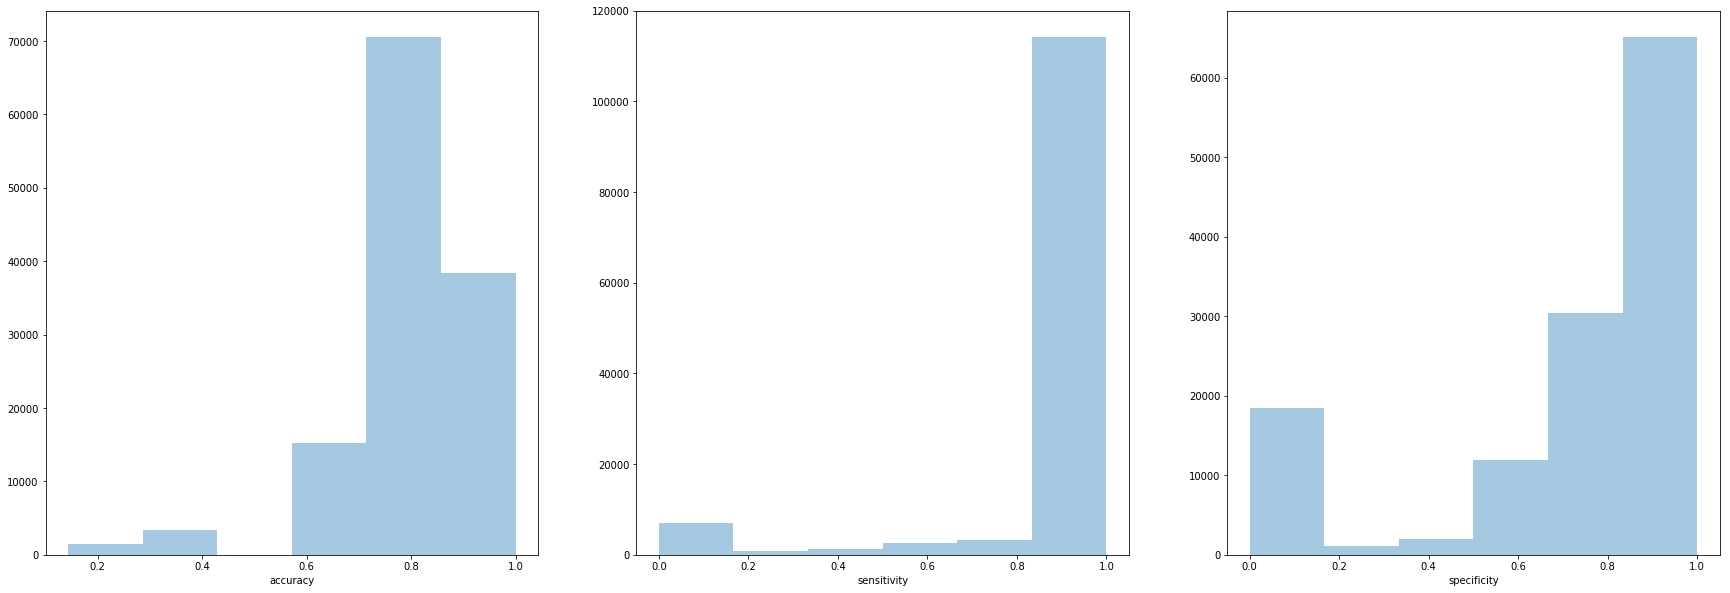

In [32]:
print('shape before filter: %s' %str(data.shape))
vdat = data[data.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
print('shape after filter: %s' %str(vdat.shape))

f, ax = plt.subplots(1,3, figsize=(30,10))

sbn.distplot(vdat['accuracy'], kde=False, bins=6, ax=ax[0])
sbn.distplot(vdat['sensitivity'], bins=6, kde=False, ax=ax[1])
sbn.distplot(vdat['specificity'], bins=6, kde=False, ax=ax[2])

plt.show()

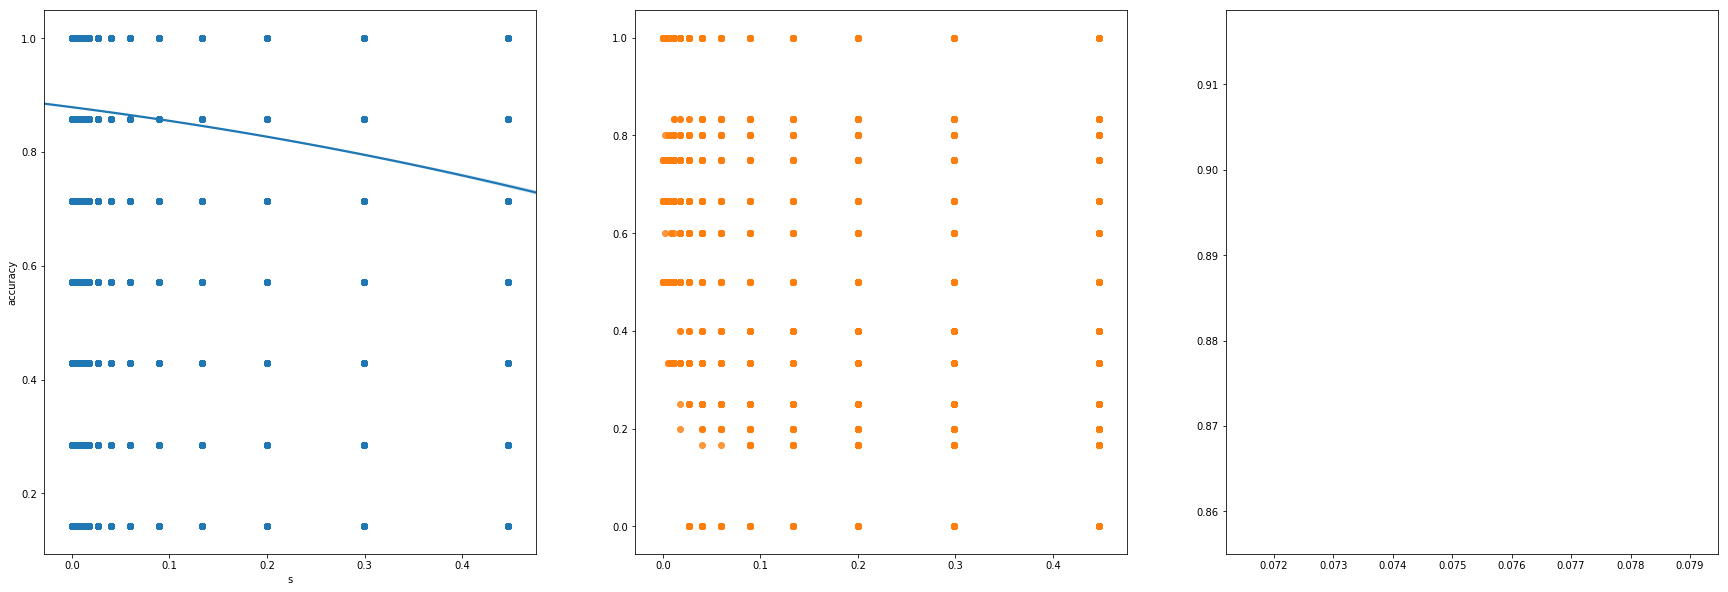

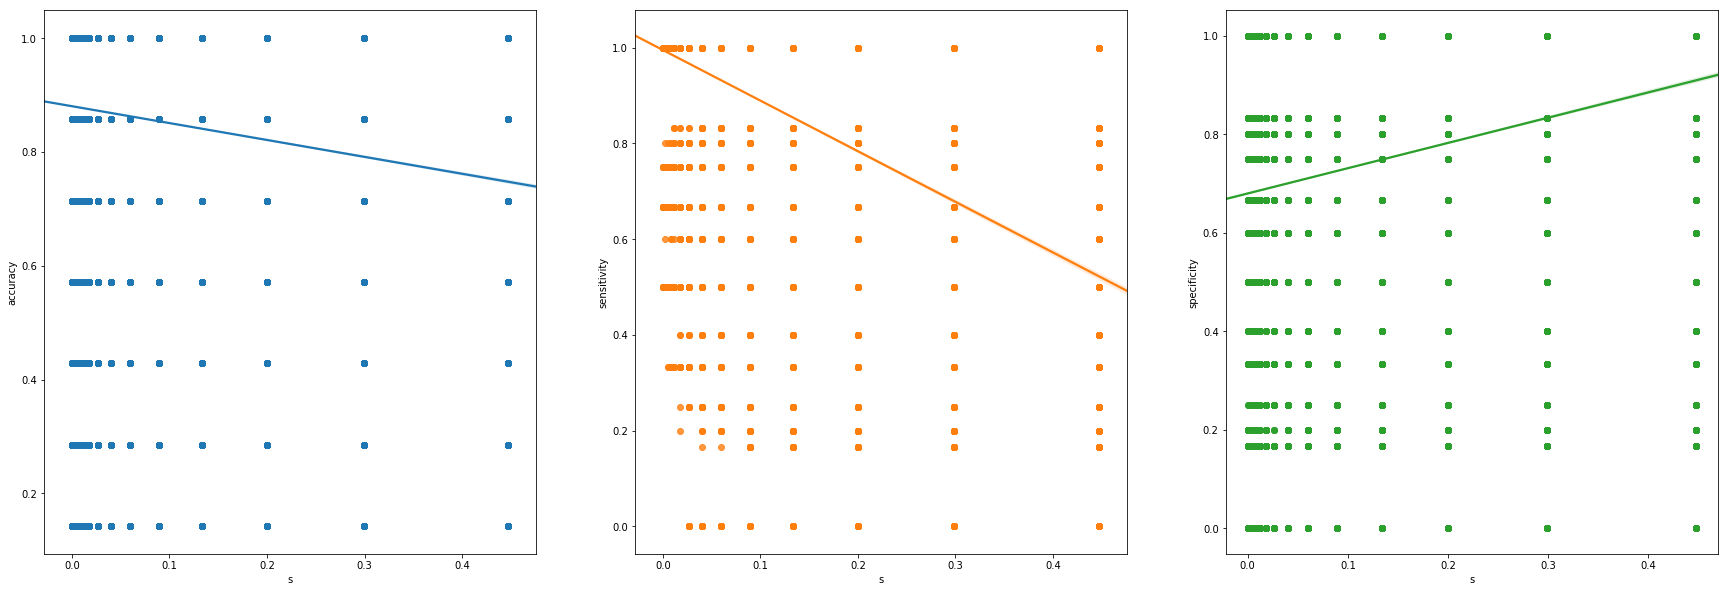

In [53]:
f, ax = plt.subplots(1,3, figsize=(30,10))

sbn.regplot(x='s', y='accuracy', logistic=False, data=vdat, ax=ax[0])
sbn.regplot(x='s', y='sensitivity', logistic=False, data=vdat, ax=ax[1])
sbn.regplot(x='s', y='specificity', logistic=False, data=vdat, ax=ax[2])

plt.show()

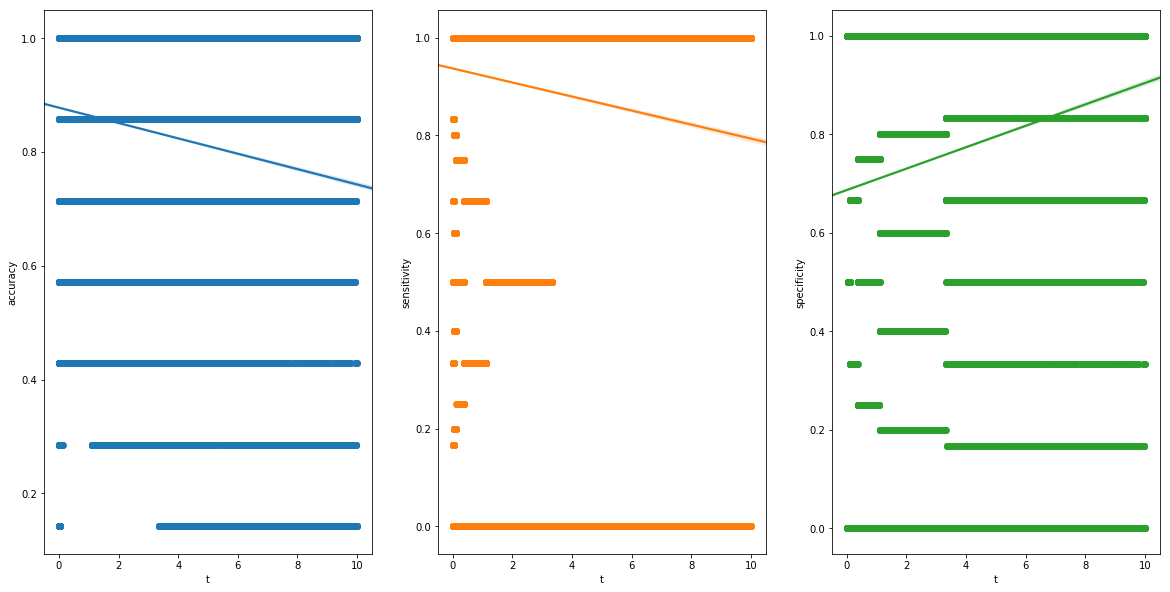

In [64]:
f, ax = plt.subplots(1,3, figsize=(20,10))

sbn.regplot(x='t', y='accuracy', logistic=False, data=vdat, ax=ax[0])
sbn.regplot(x='t', y='sensitivity', logistic=False, data=vdat, ax=ax[1])
sbn.regplot(x='t', y='specificity', logistic=False, data=vdat, ax=ax[2])

plt.show()

In [66]:
results1 = smf.ols('accuracy ~ s + t + m + b + b0 + b1', data=data).fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               accuracy   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     8222.
Date:                Sat, 17 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:01:51   Log-Likelihood:                 89585.
No. Observations:              180010   AIC:                        -1.792e+05
Df Residuals:                  180003   BIC:                        -1.791e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8739      0.003    336.114      0.000       0.869       0.879
s             -0.3476      0.003   -120.657      0.000      -0.353      -0.342
t             -0.0173      0.000   -127.423      0.000      -0.018      -0.017
m              0.1079      0.002     43.663      0.000       0.103       0.113
b              0.0168      0.001     26.249      0.000       0.016       0.018
b0             0.0014      0.000      4.804      0.000       0.001       0.002
b1            -0.0052      0.000    -40.500      0.000      -0.005      -0.005
==============================================================================
Omnibus:                    65870.082   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           334038.923
Skew:                          -1.708   Prob(JB):                         0.00
Kurtosis:                       8.734   Cond. No.                         83.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

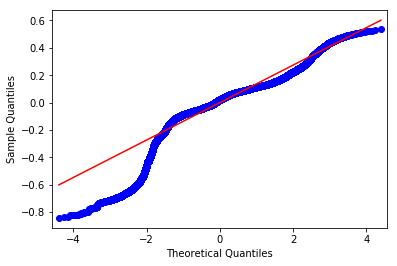

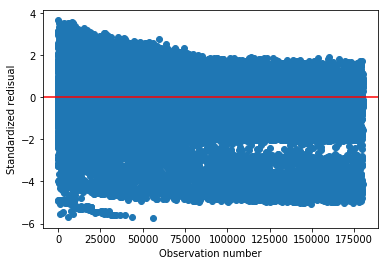

In [63]:
    # q-q plot for normality
    qq = sm.qqplot(results1.resid, line = 'r')
    plt.show()

    # plot of residuals
    stdres = pd.DataFrame(results1.resid_pearson)
    plt.plot(stdres, 'o', ls = 'None')
    l = plt.axhline(y=0, color = 'r')
    plt.ylabel('Standardized redisual')
    plt.xlabel('Observation number')
    plt.show()

    # leverage plot - takes forever
    #figure1 = sm.graphics.influence_plot(results1, size=8)
    #plt.show()